# Machine Learning Project: Linear Regression & Beyond

We first create a cell for all the libraries we will need to import for our project. We will use pandas to import and manipulate data easily through DataFrames, NumPy for linear algebra & complex operations over lists, Matplotlib for displaying 2D plots, Seaborn for displaying correlation heatmaps, scikit-learn for model engineering & some extra utilities.

In [1]:
import time
from math import sqrt

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

We set some parameters to increase the height of Matplotlib figures and pandas print outputs so they can be displayed properly in the notebook.

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

We create a function to display and analyse the results of our regressions feature-by-feature (with scatter plots & lines corresponding to the coefficients of each weight).

In [3]:
def plot_weights_data_biasless(plt, X, y, w, title, same_scale = True):
    intercept = w[0]
    w = w[1:]
    
    n = len(w)
    fig, axs = plt.subplots(2, n)
    fig.suptitle(title, fontsize=20)
    y_scale_line = (-1*((max(y)-min(y))/2), (max(y)-min(y))/2)
    y_scale = (min(y), max(y))
    
    x_minimums = X.T.min(axis = 1)
    x_maximums = X.T.max(axis = 1)
    x_size = x_maximums - x_minimums
    max_size = max(x_size)
    
    x = np.linspace(-100, 100, 100)
    for i in range(n):
        if same_scale:
            diff_size = max_size - x_size[i]
            x_scale = (x_minimums[i] - diff_size/2, x_maximums[i] + diff_size/2)            # We make it so all x scales are on the same scale
            
            if (n > 1):
                axs[0][i].set_xlim(x_scale)
                axs[0][i].set_ylim(y_scale)
            else:
                axs[0].set_xlim(x_scale)
                axs[0].set_ylim(y_scale)
                
            heatmap, xedges, yedges = np.histogram2d(np.concatenate((X[:, i], x_scale)),    # We add a point in the upper-left corner and upper-right corner of the heatmap
                                                     np.concatenate((y, y_scale)), bins=50) # so all heatmaps will have the same edges and be displayed correctly
        else:
            heatmap, xedges, yedges = np.histogram2d(X[:, i], y, bins=50)
        
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        if (n > 1):
            axs[0][i].imshow(heatmap.T, extent=extent, origin='lower')

            axs[1][i].set_xlim((-2, 2))
            axs[1][i].set_ylim(y_scale_line)
            axs[1][i].plot(x, w[i]*x, c="red", linewidth=2)
        else:
            axs[0].imshow(heatmap.T, extent=extent, origin='lower')

            axs[1].set_xlim((-2, 2))
            axs[1].set_ylim(y_scale_line)
            axs[1].plot(x, w[i]*x, c="red", linewidth=2)
        
    fig.tight_layout()

# First Dataset: Analysis & Model Fitting of the Powerplant Dataset

The dataset can found at: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant. The dataset contains 4 variables and one output.

In [4]:
def load_data_excel(excel_path, y_label, drops=[]):
    df = pd.read_excel(excel_path, sheet_name=None)  # Excel datasets might be spread over multiple sheets. To concactenate all the sheets into one DataFrame,
    df = pd.concat(df, ignore_index=True)            # we use the "sheet_name=None" argument when reading and then pd.concat with "ignore_index=True"
    
    for drop in drops:                               # We add an optional "drops" argument, telling which columns to drop as soon as the data is loaded
        df = df.drop(drop, axis=1)
    
    y = df[y_label].to_numpy()                       # y_label tells which column corresponds to the ouput of our ML model, the value we will try to predict
    X = df.drop(y_label, axis=1).to_numpy()
    
    return X, y, df

In [5]:
X, y, df = load_data_excel("powerplant.xlsx", "PE")

print(df.columns)
print()
print(df.sample(10))
print()
print(df.describe())

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

          AT      V       AP     RH      PE
36110  14.84  41.48  1017.26  63.42  460.30
2224   29.64  69.51  1012.13  44.65  428.69
19473  29.77  69.98  1013.32  69.60  430.65
22812  22.95  63.94  1013.87  80.37  447.13
37436  25.68  59.44  1012.33  67.29  444.36
2351   23.43  61.47  1007.84  87.11  448.01
18592   7.61  39.37  1015.84  83.73  483.74
12341  19.69  39.72  1001.49  60.34  456.55
16187   6.59  39.37  1020.34  77.92  488.17
18744  16.54  42.86  1014.85  78.00  465.26

                 AT             V            AP            RH            PE
count  47840.000000  47840.000000  47840.000000  47840.000000  47840.000000
mean      19.651231     54.305804   1013.259078     73.308978    454.365009
std        7.452162     12.707362      5.938535     14.599658     17.066281
min        1.810000     25.360000    992.890000     25.560000    420.260000
25%       13.510000     41.740000   1009.100000     63.327500    439.750000
50%  

## Part I: Linear Regression from Scratch

To normalize the features, we implement a function with two modes, "min-max" or "z-score" to use either of those methods for feature scaling. The function also add a 1s column for the bias (intercept) of the linear regression.

In [6]:
def normalizeFeatures(X, mode="min-max"):   # Put all columns (classes) on the same scale (scaling) and brings them on the origin [0; 1]
                                            # And add a 1s column for the factor associated to the bias 

    X_t = X.T # Go from the individual points as lines to columns as lines (by default numpy operations are applied line by line)
              #
              # x11, x12, x13, x14    x11, x21, x31
              # x21, x22, x23, x24 -> x12, x22, x32
              # x31, x32, x33, x34    x13, x23, x33
              #                       x14, x24, x34

    # For normalization we suppose no variable has always the same value (otherwise there would a division by 0)
    # If a variable has always the same value, it should be removed from the dataset as it is pointless in the linear regression
    
    
    if (mode == "min-max"): # Feature scaling using minimums and maximums
        minimums = X_t.min(axis = 1)[:, None] # Create a new axis to convert scalars to 1-element arrays
        maximums = X_t.max(axis = 1)[:, None] # Create a new axis to convert scalars to 1-element arrays
        X_t = (X_t - minimums) / (maximums - minimums)

    elif (mode == "z-score"): # Feature scaling using z_scores
        X_t = (X_t - X_t.mean(axis = 1)[:, None]) / X_t.std(axis = 1)[:, None]

    X = X_t.T
    X = np.c_[np.ones((X.shape[0], 1)), X] # Add a 1s column to the new scaled matrix for the bias for matrix multiplications
    
    return X

We implement two cost functions, one using the classical least-squares logic, and just for fun, one for the absolute value of the error (that also describes a convex function).

For the reminder of this notebook, we will use the 'at' operator (@) for matrix multiplication (https://www.python.org/dev/peps/pep-0465/)

In [7]:
def costFunction(w, X, y, function="squares"):
    error = y - (X @ w)                                # The cost function returns a value that is a convex function of the error (usually the sum of its squares)
    if (function == "squares"):
        return (1/(2*len(X))) * (error.T @ error)      # Here we impletement the least squares cost function
    elif (function == "absolute"):
        return (1/(2*len(X))) * np.sum(np.abs(error))  # Here, just for fun, we implement an absolute value cost function (convex as well, corresponding 
                                                       # to the sum of the absolute values of the error)

For the implementation of the gradient descent, we follow the general algorithm : while the maximal iteration has not been reached or the cost difference isn't small enough, we calculate new weights, equal to the previous weights minus the gradient of the cost function over the weights. To simplify the calculations "from scratch", we can use matrix multiplications to modelize the iterative substraction of each component of the gradient. Depending on the cost function used, we need to use the right gradient (derivative) formula of the function over 𝛿w. When the cost difference is negative (meaning the learning rate (α) is too large, as the function is convex), we decrease the learning rate.

In [8]:
def gradientDescent(alpha, w, X, y, iterations, delta, print_every=500, print_first=10, function="squares"):
    previous_cost = -1
    curr_cost = -1
    i = 0
    costs = []
    decrease_factor = 0.5

    m = len(X)
    
    previous_weights = None
    
    start = time.time() * 1000
    first_print = True
    while (i < iterations and (i < 1 or previous_cost-curr_cost > delta or previous_cost-curr_cost < 0)):
        if (previous_cost-curr_cost < 0 and i > 1):
            alpha = alpha * decrease_factor
            w = previous_weights
        

        # Since the cost function is the sum of the costs associated to each errors, the gradient of the cost function
        # can be expressed as the sum of the derivatives for the costs associated to the error (since the derivative of a sum is the sum of the derivatives)

        # The gradient can simply be calculated as ∇J(Xw - y) = X_t * J'(Xw - y) (because of the chain rule)
    
        error = X @ w - y                                                 # We use the predicted y (hypothesis) - true y notation instead of the usual true y - predicted y
                                                                          # to simply calculations
        if (function == "squares"):
            gradient = (1/m) * (X.T @ error)                              # The derivative of g(x) = (f(x))² is g'(x) = f'(x) * (2*f(x))
        elif (function == "absolute"):
            error = (X @ w) - y
            gradient = (1/(2*m)) * (X.T @ (error / ( np.abs(error) )))    # The derivative of g(x) = abs(f(x)) is g'(x) = f'(x) * (f(x)/abs(f(x)))
            
        previous_weights = w
        w = w - alpha*gradient
        
        previous_cost = curr_cost
        curr_cost = costFunction(w, X, y, function)

        costs.append(curr_cost)                                           # We keep costs in memory to plot them afterwards

        if ((print_every > 0 and i%print_every == 0) or (print_first > 0 and i < print_first)): # We only print the "print_first" first iterations and then every
                                                                                                # "print_every" iterations
            if (first_print):
                print("{: >10} {: >40} {: >40} {: >20}".format("curr iter", "cost difference", "curr cost", "alpha"))
                print()
                first_print = False
            
            print("{: >10} {: >40} {: >40} {: >20}".format(i, previous_cost-curr_cost if previous_cost != -1 else "N/A", curr_cost, alpha))

        i+=1  
    
    end = time.time() * 1000
    
    print()
    print("Weights found: ", w)

    return np.round(w, 3), end-start, costs, i, curr_cost

We implement our own functions to calculate the mean absolute error, the root mean squared error and the r squared (coefficient of determination) of our regressions.

We can reuse our cost function implementation to calculate the errors. However, for the rest of the notebook, we will use scikit-learn's error functions to calculate our errors quicker and with more precision.

In [9]:
def meanAbsoluteError(X, w, y):     # The sum of the absolute values of the error divided by the number of individuals
    return 2*costFunction(w, X, y, function="absolute")
    
def rootMeanSquaredError(X, w, y):  # The sum of the squares of the error divided by the number of individuals
    return sqrt(2*costFunction(w, X, y))

def r2(X, w, y):                    # One minus the error squared divided by the variance squared
    error = y - (X @ w)
    rss = error.T @ error
    
    var = y-y.mean()
    tss = var.T @ var

    return 1 - rss/tss

For our linear regression algorithm itself, we simply generate random weights between -10 and 10, with number of columns + 1 (the bias) components, normalize our features and launch our gradientDescent function.

In [10]:
def linear_regression_from_scratch(path, y_label):
    X, y, df = load_data_excel(path, y_label)
    
    w = np.random.randint(-10, 10, len(X[0]) + 1)
    X_normalized = normalizeFeatures(X)
    
    all_results = []
    for func in ["squares", "absolute"]:
        print(func.capitalize(), "Cost Function Gradient Descent:\n")
        results = gradientDescent(20, w.copy(), X_normalized, y, 100000, 0.000001, 1000, 10, func)
        all_results.append(results)
        
        print()
        print("Initial weights: ", w, "\n")
        print("Least-squares cost function:")
        
        print("Execution time: %.2f ms" % results[1])
        print("Final w: ", results[0])
        print("Iterations: ", results[3])
        print("Score: %.2f (%s)" % (results[4], func.capitalize()))
    
        print()
        print("Mean Absolute Error: %.2f (from scratch), %.2f (sklearn)" % ( meanAbsoluteError(X_normalized, results[0], y),
                                                                             mean_absolute_error(y, X_normalized @ results[0]) ))
        print("Root Mean Squared Error: %.2f (from scratch), %.2f (sklearn)" % ( rootMeanSquaredError(X_normalized, results[0], y),
                                                                                 mean_squared_error(y, X_normalized @ results[0], squared=False) ))
        print("R2 Score: %.2f (from scratch), %.2f (sklearn)" % ( r2(X_normalized, results[0], y),
                                                                  r2_score(y, X_normalized @ results[0]) ))
        
        print()

    fig, ((ax1, ax2)) = plt.subplots(1, 2)
    ax1.plot(np.linspace(0, all_results[0][3], all_results[0][3]), all_results[0][2])
    ax1.set_title("Least-squares cost function")
    ax2.plot(np.linspace(0, all_results[1][3], all_results[1][3]), all_results[1][2])
    ax2.set_title("Absolute value cost function")
    fig.tight_layout(pad=3.0)
    
    fig.suptitle("Evolution of the cost function with increasing iterations of the gradient descent", fontsize=20, y=1.08)

    plot_weights_data_biasless(plt, X, y, all_results[0][0], "Square Cost Function - w: " + str(all_results[0][0]))
    plot_weights_data_biasless(plt, X, y, all_results[1][0], "Absolute Value Cost Function - w: " + str(all_results[1][0]))
    
    return X, w, y, df

PE is the column containing our output variable. We launch the notebook in the same folder as the "powerplant.xlsx" file, containing our dataset.

Squares Cost Function Gradient Descent:

 curr iter                          cost difference                                curr cost                alpha

         0                                      N/A                       195415802.08396953                   20
         1                      -360631639165.71313                        360827054967.7971                   20
         2                       274769978290.70715                        86057076677.08997                 10.0
         3                       -37811873884371.17                       37897930961048.266                 10.0
         4                        29304899224758.07                        8593031736290.197                  5.0
         5                       -849444418868419.2                        858037450604709.5                  5.0
         6                        684313333963590.0                       173724116641119.44                  2.5
         7                      -3338431968640

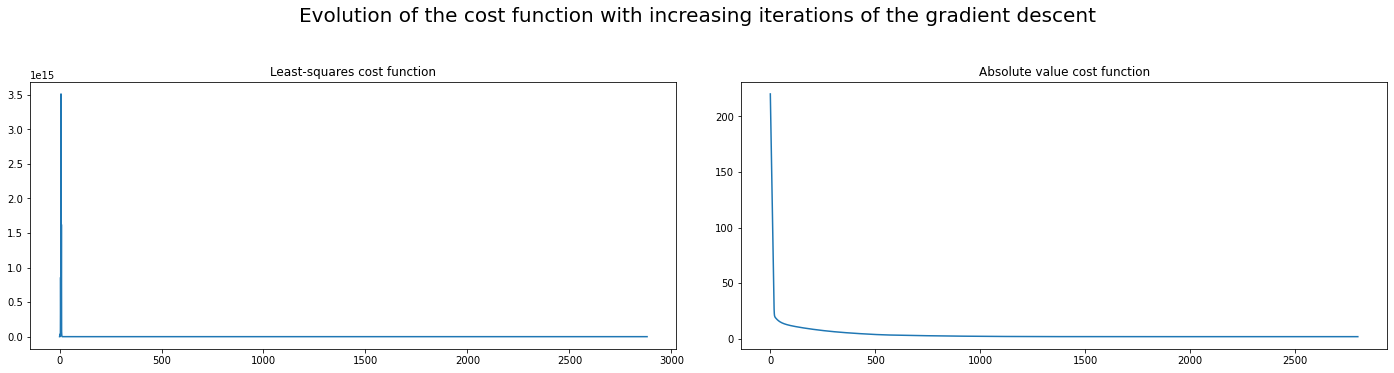

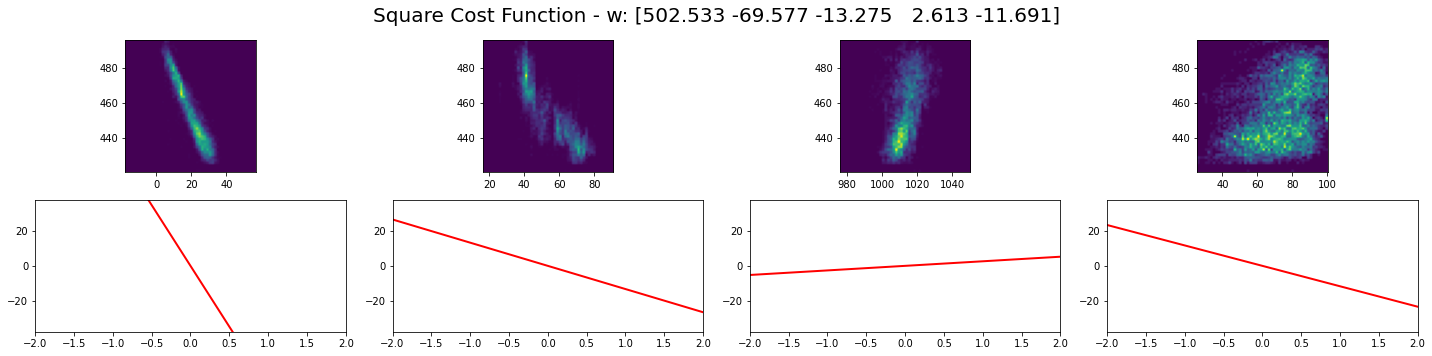

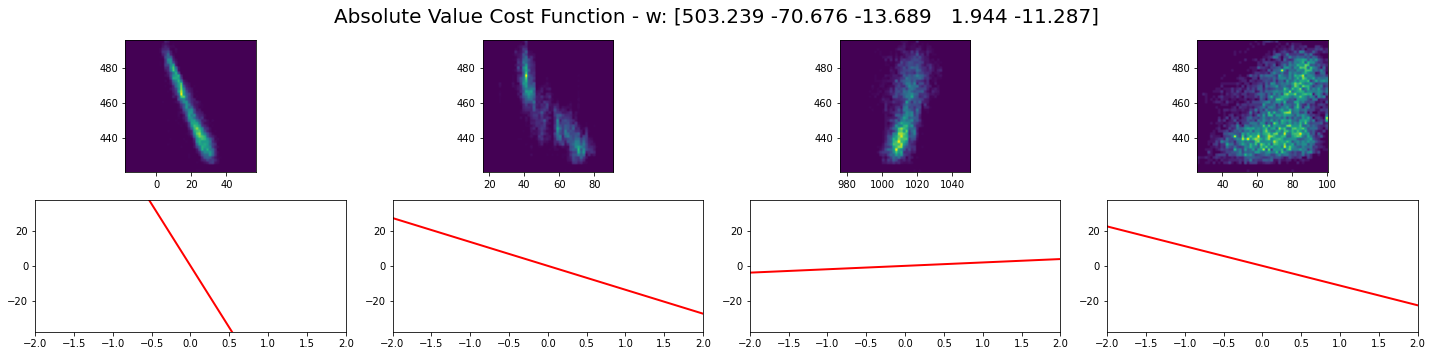

In [11]:
X, w, y, df = linear_regression_from_scratch("powerplant.xlsx", "PE")

## Part II: Linear Regression using Scikit Learn

To use scikit-learn's linear regression model, we simply scale our features using the fit_transform method of a MinMaxScaler instance (from the sklearn.preprocessing module) and create an instance of the LinearRegression class from the linear_model module.

Since the dataset contains a number of samples orders of magnitude greater than columns, it is unnecessary to train and test the model on differents subsets of the dataset.

To retrieve the bias and the weights, we get the intercept_ and coef_ attributes from our LinearRegression instance. We create a function to display the statistics of our linear regression (errors & weights).

We obtain the same result with scikit-learn as with our linear regression implementation from scratch; with an R squared of 0.93, we see that we predict the model very accurately.

In [12]:
def linear_regression_stats(w, X, y, y_pred, columns, title="Linear Regression", X_display=False):
    print("Weights:", len(w), "components")
    print()
    
    dict_w = dict(zip(["Bias"] + list(columns), w))
    print("Coefficients:")
    
    for k, v in dict_w.items():
        print(f'{k:<20} {v}')
    
    print()
    print("Mean absolute error: %.2f"
          % mean_absolute_error(y, y_pred))

    print("Root mean squared error: %.2f"
          % mean_squared_error(y, y_pred, squared=False))

    print("Coefficient of determination: %.2f"
          % r2_score(y, y_pred))
    
    if(X_display is not False):
        plot_weights_data_biasless(plt, X_display, y, w, title)
    
    
    return

In [13]:
def linear_regression_sklearn(path, y_label):
    X, y, df = load_data_excel(path, y_label)

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)
    
    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop(y_label, axis=1).columns, "Scikit Learn Linear Regression", X)
    
    return X, w, y, df

Weights: 5 components

Coefficients:
Bias                 502.69952629563875
AT                   -69.80621266422945
V                    -13.146102949136466
AP                   2.508771758184392
RH                   -11.790836077564483

Mean absolute error: 3.63
Root mean squared error: 4.56
Coefficient of determination: 0.93


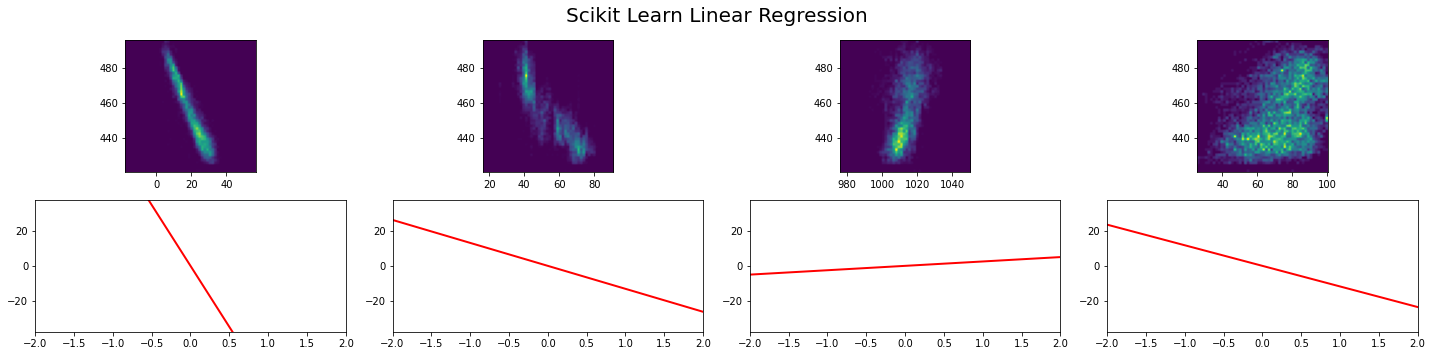

In [14]:
X, w, y, df = linear_regression_sklearn("powerplant.xlsx", "PE")

## Part III: Linear Regression using the Normal Equation (from scratch)

In this part, we code all the basic linear algebra functions to calculate our normal equation from scratch.

In [15]:
h = lambda x, w: [sum(column*weight) for column, weight in line for line in zip(x, w)]

def transposeMatrix(m):
    return list(map(list,zip(*m)))

def createOnesVector(n):
    vector = []
    for i in range(n):
        vector.append(1)
    
    return vector

def normalizeFeaturesMatrix(X):
    X_t = transposeMatrix(X)
    for column in X_t:
        maximum = max(column)
        minimum = min(column)
        
        for i in range(len(column)):
            column[i] = (column[i] - minimum)/(maximum-minimum)
    
    first_column = createOnesVector(len(X))
    X_t.insert(0, first_column)
    
    return transposeMatrix(X_t)

def productMatrix(X, Y):
    #print("(", len(X), ",", len(X[0]), "), (", len(Y), ",", len(Y[0]), ")")
    result = []
    for i in range(len(Y)):
       if isinstance(Y[i], (int, float)):
           Y[i] = [Y[i]]
           
    for i in range(len(X)):
       if isinstance(X[i], (int, float)):
           X[i] = [X[i]]
           
    for i in range(len(X)):
        result.append([])
        for j in range(len(Y[0])):
            result[i].append(0)
    
    # iterate through rows of X    
           
    for i in range(len(X)):
       # iterate through columns of Y
       for j in range(len(Y[0])):
           # iterate through rows of Y
           for k in range(len(Y)):
               result[i][j] += X[i][k] * Y[k][j]

    return result    

def getMatrixMinor(m,i,j):
    return [row[:j] + row[j+1:] for row in (m[:i]+m[i+1:])]

def getMatrixDeterminant(m):
    #base case for 2x2 matrix
    if len(m) == 2:
        return m[0][0]*m[1][1]-m[0][1]*m[1][0]

    determinant = 0
    for c in range(len(m)):
        determinant += ((-1)**c)*m[0][c]*getMatrixDeterminant(getMatrixMinor(m,0,c))
    return determinant

def getMatrixInverse(m):
    determinant = getMatrixDeterminant(m)
    #special case for 2x2 matrix:
    if len(m) == 2:
        return [[m[1][1]/determinant, -1*m[0][1]/determinant],
                [-1*m[1][0]/determinant, m[0][0]/determinant]]

    #find matrix of cofactors
    cofactors = []
    for r in range(len(m)):
        cofactorRow = []
        for c in range(len(m)):
            minor = getMatrixMinor(m,r,c)
            cofactorRow.append(((-1)**(r+c)) * getMatrixDeterminant(minor))
        cofactors.append(cofactorRow)
    cofactors = transposeMatrix(cofactors)
    for r in range(len(cofactors)):
        for c in range(len(cofactors)):
            cofactors[r][c] = cofactors[r][c]/determinant
    return cofactors

We apply the normal equation formula ( (X_t * X)^-1 * (X_t * y) ) and then display the obtained weights.

In [16]:
def linear_regression_normal_equation(path, y_label):
    
    X, y, df = load_data_excel(path, y_label)

    X_normalized = normalizeFeaturesMatrix(X)
    X_t = transposeMatrix(X_normalized)

    w = productMatrix (
            getMatrixInverse (
                productMatrix(X_t, X_normalized)
            ), 
                productMatrix(X_t, list(y))
        )

    linear_regression_stats(w, X_normalized, y, productMatrix(X_normalized, w),
                            df.drop(y_label, axis=1).columns, "Linear Regression Using the Normal Equation", X)
    
    return X, w, y, df

There are almost the same as before, and just like with scikit-learn, we obtain an R squared of 0.93, meaning our previous implementations were correct (for a small number of features, the normal equation predicts the exact optimal weights for the global minimum of the cost function).

Weights: 5 components

Coefficients:
Bias                 [502.69952629770523]
AT                   [-69.80621266353046]
V                    [-13.1461029532893]
AP                   [2.508771759332376]
RH                   [-11.790836079060682]

Mean absolute error: 3.63
Root mean squared error: 4.56
Coefficient of determination: 0.93


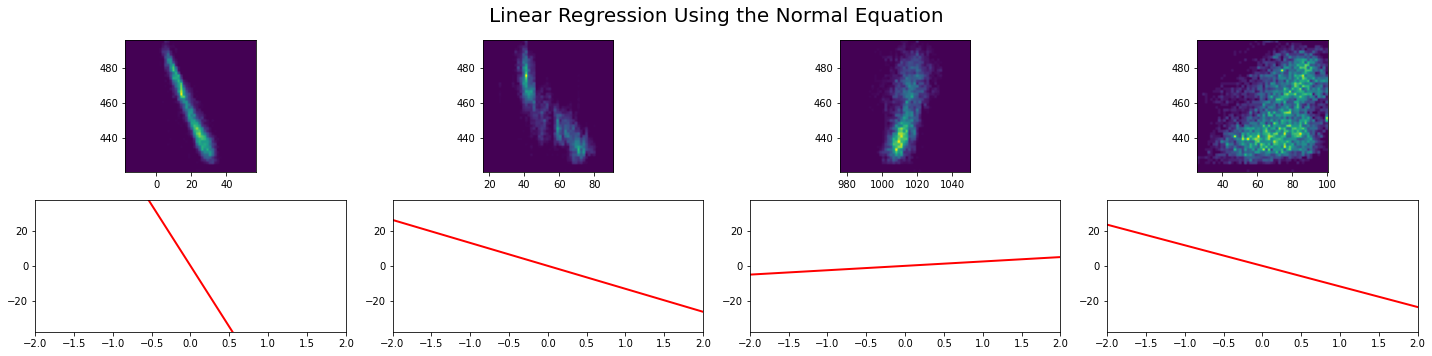

In [17]:
X, w, y, df = linear_regression_normal_equation("powerplant.xlsx", "PE")

# Second Dataset: Analysis & Model Fitting of the Bike Sharing Dataset

The original dataset can found at: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset. The modified dataset can be found in the same project folder as the notebook. It has 12 feature columns and one output column ("demand", corresponding to "cnt" in the original dataset).

We hardcode our dataset loading with a custom function that replaces the dayOfWeek column (a string column) with an integer column, corresponding to the index of the day in a week.

In [18]:
def load_bike_data():
    df = pd.read_csv("Bike Rental UCI dataset.csv")

    days_dict = {"Mon": 0, "Tue": 1, "Wed": 2, "Thr": 3, "Fri": 4, "Sat": 5, "Sun": 6}
    df['dayOfWeek'] = df['dayOfWeek'].map(days_dict)

    y = df['demand'].to_numpy()
    X = df.drop('demand', axis=1).to_numpy()
    
    return X, y, df

In [19]:
X, y, df = load_bike_data()

print(df.columns)
print()
print(df.sample(10))

unique = []
unique_counts = []
unique_types = []
for column in df.columns:
    unique_column = df[column].unique()
    string = " - ".join([str(i) for i in unique_column])
    if len(string) > 40:
        string = string[:36] + " ..."
    unique.append(string)
    unique_counts.append(len(unique_column))

df_unique = pd.DataFrame(zip(df.columns, unique_counts, [str(dtype) for dtype in df.dtypes], unique),
                         columns = ["Column names", "# Unique", "Data Type", "Unique values"])

print()
print(df_unique)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'dayOfWeek', 'days', 'demand'], dtype='object')

       season  yr  mnth  hr  holiday  workingday  weathersit  temp   hum  windspeed  dayOfWeek  days  demand
4151        3   0     6  21        0           0           2  0.70  0.54     0.1045          6   172     183
4895        3   0     7  21        0           1           1  0.74  0.48     0.1045          2   203     245
7848        4   0    11  16        0           1           1  0.56  0.60     0.1940          0   327     264
9870        1   1     2   7        0           1           1  0.22  0.64     0.0000          1   411     279
2240        2   0     4   5        0           1           2  0.32  0.87     0.1940          4    93       9
10611       2   1     3   6        0           1           2  0.50  0.88     0.0000          4   442     116
17052       4   1    12   7        0           1           1  0.36  0.93     0.1343 

We display the intercorrelations of our columns to get some insights about each feature. As we can see, the hour of the day (hr), the temperature (temp), the year (yr) and "workingday" (indicated whether the day is a working day) have the highest correlations with our output column (demand).

Most other columns have a high intercorrelation with the previously described variables, meaning they do not carry more information than those variables (i.e. a PCA would probably only contain variables very similar to those 4 described, and not lose information).

In [20]:
def heatmap_correlations():
    X, y, df = load_bike_data()
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

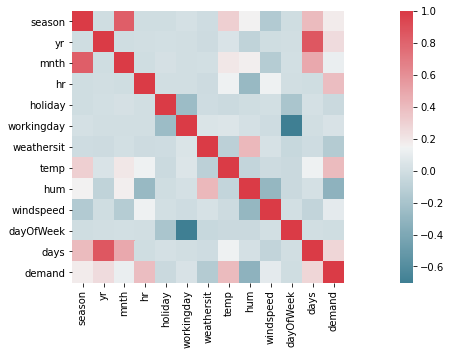

In [21]:
heatmap_correlations()

## Part I: Raw Linear Regression

We reuse the same functions/logic as before to implement the linear regressions for the bike sharing dataset.

In [22]:
def linear_regression_from_scratch_bike():
    
    X, y, df = load_bike_data()

    X_t = X.T

    w = np.random.randint(-10, 10, 13)
    X_normalized = normalizeFeatures(X)

    all_results = []
    for func in ["squares", "absolute"]:
        print(func.capitalize(), "Cost Function Gradient Descent:\n")
        results = gradientDescent(20, w.copy(), X_normalized, y, 100000, 0.000001, 5000, 10, func)
        all_results.append(results)
        
        print()
        print("Initial weights: ", w, "\n")
        print(func.capitalize(), "cost function:")
        
        print("Execution time: %.2f ms" % results[1])
        print("Final w: ", results[0])
        print("Iterations: ", results[3])
        print("Score: %.2f (%s)" % (results[4], func.capitalize()))
    
        print()
        print("Mean Absolute Error: %.2f (from scratch), %.2f (sklearn)" % ( meanAbsoluteError(X_normalized, results[0], y),
                                                                             mean_absolute_error(y, X_normalized @ results[0]) ))
        print("Root Mean Squared Error: %.2f (from scratch), %.2f (sklearn)" % ( rootMeanSquaredError(X_normalized, results[0], y),
                                                                                 mean_squared_error(y, X_normalized @ results[0], squared=False) ))
        print("R2 Score: %.2f (from scratch), %.2f (sklearn)" % ( r2(X_normalized, results[0], y),
                                                                  r2_score(y, X_normalized @ results[0]) ))
        
        print()

    fig, ((ax1, ax2)) = plt.subplots(1, 2)
    ax1.plot(np.linspace(0, all_results[0][3], all_results[0][3]), all_results[0][2])
    ax1.set_title("Least-squares cost function")
    ax2.plot(np.linspace(0, all_results[1][3], all_results[1][3]), all_results[1][2])
    ax2.set_title("Absolute value cost function")
    fig.tight_layout(pad=3.0)
    
    fig.suptitle("Evolution of the cost function with increasing iterations of the gradient descent", fontsize=20, y=1.08)
    
    return X, w, y, df

Squares Cost Function Gradient Descent:

 curr iter                          cost difference                                curr cost                alpha

         0                                      N/A                        116316723.4560647                   20
         1                       -652644168094.1022                        652760484817.5582                   20
         2                        493897747385.7277                        158862737431.8305                 10.0
         3                       -216847129729158.9                       217005992466590.75                 10.0
         4                       165650513642864.72                        51355478823726.03                  5.0
         5                  -1.6550308173240332e+16                   1.6601663652064058e+16                  5.0
         6                   1.2900086891849036e+16                       3701576760215023.0                  2.5
         7                  -2.630989833635736

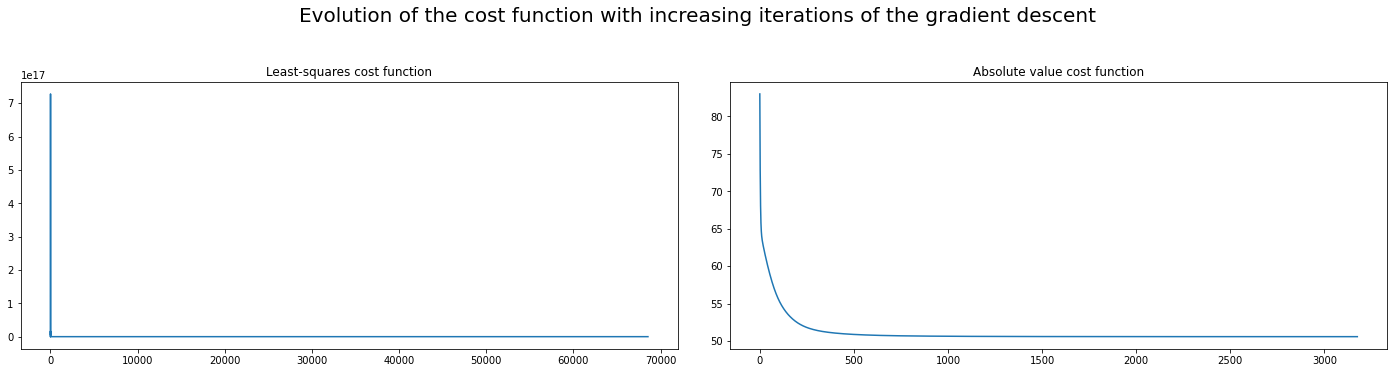

In [23]:
X, w, y, df = linear_regression_from_scratch_bike()

In [24]:
def linear_regression_scikit_bike():
    X, y, df = load_bike_data()

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    
    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset)")
    
    return X, w, y, df

In [25]:
X, w, y, df = linear_regression_scikit_bike()

Weights: 13 components

Coefficients:
Bias                 12.70222800138481
season               60.136022510799975
yr                   130.00364157932958
mnth                 44.9430599627203
hr                   177.1774698565802
holiday              -24.386075025499807
workingday           4.517243675373237
weathersit           -11.450442809762603
temp                 277.2098848446928
hum                  -196.8266250443891
windspeed            25.33532207207788
dayOfWeek            1.0187825756877227
days                 -97.41800717998706

Mean absolute error: 106.09
Root mean squared error: 141.96
Coefficient of determination: 0.39


In [26]:
def linear_regression_normal_equation_bike():
    X, y, df = load_bike_data()
    
    X_normalized = normalizeFeatures(X)
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, random_state = 1, test_size=0.2)

    start = time.time() * 1000

    w = np.linalg.inv( X_train.T @ X_train ) @ ( X_train.T @ y_train )
    print(len(w))
    
    end = time.time() * 1000
    
    
    linear_regression_stats(w, X_normalized, y_test, X_test @ w,
                            df.drop("demand", axis=1).columns,
                            "Linear Regression Using the Normal Equation (Bike Sharing Dataset)")
    
    return X, w, y, df

In [27]:
X, w, y, df = linear_regression_normal_equation_bike()

13
Weights: 13 components

Coefficients:
Bias                 15.079934916228012
season               59.339308082236016
yr                   138.8077656327514
mnth                 55.21086379577173
hr                   175.21107201612472
holiday              -27.156028085155583
workingday           5.675966661051689
weathersit           -12.155998101331193
temp                 276.5409816263464
hum                  -198.53619282883324
windspeed            20.51289595746175
dayOfWeek            1.864165235446272
days                 -116.36340328166261

Mean absolute error: 106.45
Root mean squared error: 141.72
Coefficient of determination: 0.40


## Part II: Data Exploration

The normal equation is slightly more effective than the linear regression, but overrall, the R squared coefficient found (0.4) is very mediocre. This is likely due to the fact that our hr, yr, weathersit and season columns are treated as integer columns (with values increasing in an ascending order), even though there is no logical order relationship between the different states of those variables; if it was sure that there was a predefined linear relationship between the hour of the day and the demand, we could reorganize the values so that each ascending value corresponds to a time of day where there is linearly more demand. However, we will surely need to reengineer our variables in another way. We can visualize the difference between the predicted values of our linear model and the actual values by aggregating over our different "cyclical"/bianry columns.

In [28]:
def data_exploration_bike():
    X, y, df = load_bike_data()
    
    w = np.linalg.inv( X.T @ X ) @ ( X.T @ y )
    y_pred = X @ w
    df['demand_pred'] = y_pred
    
    print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred))
    
    print(len(df))
    print("Ten random samples from the dataset:\n")
    print(df.sample(10).head(10))
    
    
    cyclical_columns = ['season', 'weathersit', 'hr', 'dayOfWeek', 'workingday', 'holiday', 'yr']
    
    for feature in cyclical_columns:
        df_agg = df.groupby(feature).agg(["mean", "median", "var"])
        
        print("\n")
        print(df_agg[["demand", "demand_pred"]].head(10))
        
        bar_width = 0.3
        fig, axs = plt.subplots(1, len(df_agg["demand"].columns))
        
        for i, column in enumerate(df_agg["demand"].columns):
        
            axs[i].bar(df_agg.index - bar_width/2, df_agg["demand"][column], bar_width, label='y true')
            axs[i].bar(df_agg.index + bar_width/2, df_agg["demand_pred"][column], bar_width, label='y predicted')   
            axs[i].legend()
            axs[i].set_title(column, fontsize=20)

            axs[i].set_xticks(df_agg.index)

        fig.suptitle(feature + ": comparison between truth and prediction", fontsize=20, y=1.08)


Coefficient of determination: 0.39
17379
Ten random samples from the dataset:

       season  yr  mnth  hr  holiday  workingday  weathersit  temp   hum  windspeed  dayOfWeek  days  demand  demand_pred
5940        3   0     9   1        0           0           2  0.62  0.94     0.0000          5   247      83    42.268440
13530       3   1     7  23        0           0           1  0.68  0.79     0.1642          6   563     123   344.168922
10596       2   1     3  15        0           1           1  0.62  0.69     0.1940          3   441     304   270.436504
7899        4   0    11  19        0           1           2  0.32  0.57     0.2836          2   329     279   198.405554
12720       2   1     6   5        0           1           2  0.60  0.78     0.1940          1   530      37   167.817654
14341       3   1     8  18        0           0           2  0.66  0.69     0.4627          5   597     383   324.397225
6394        4   0     9   0        0           1           1  0.60 

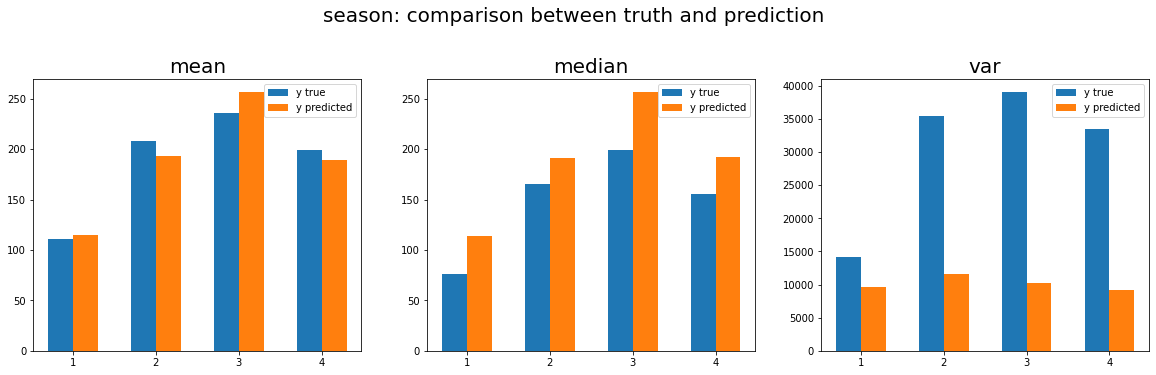

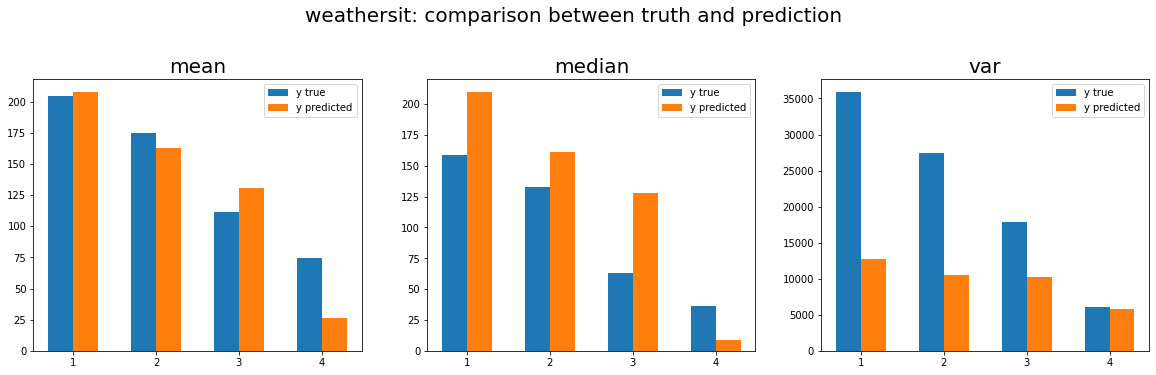

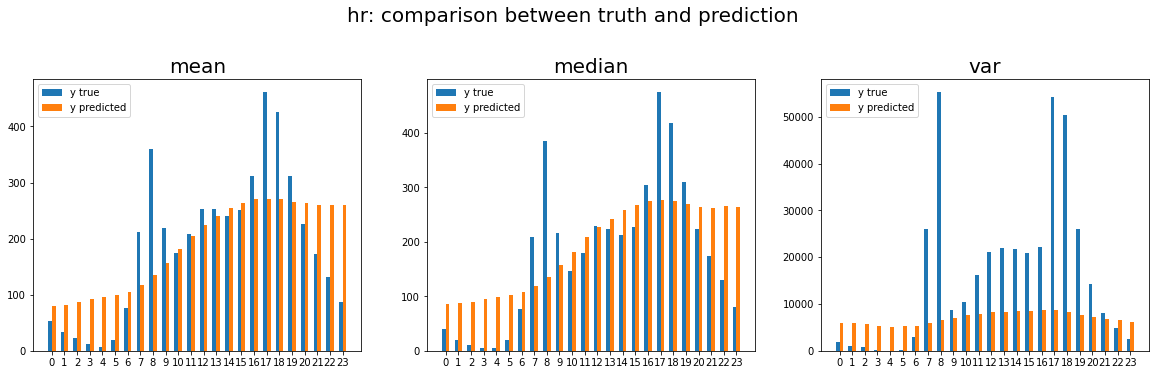

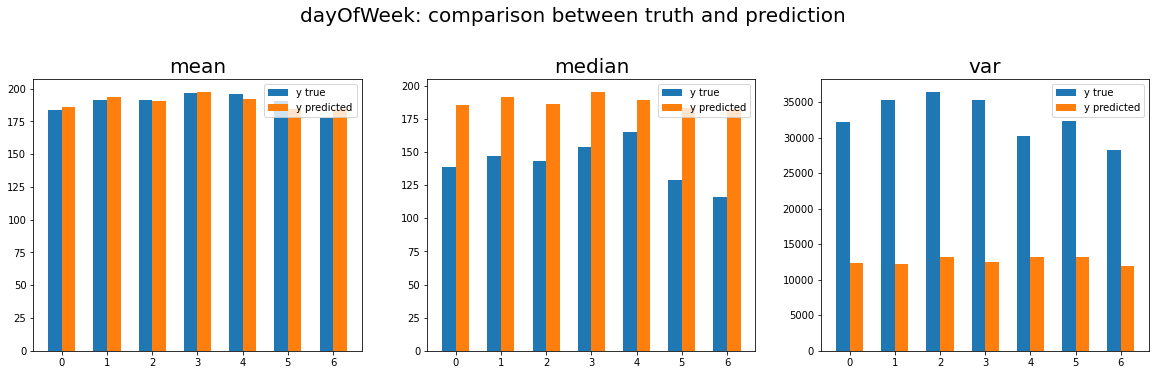

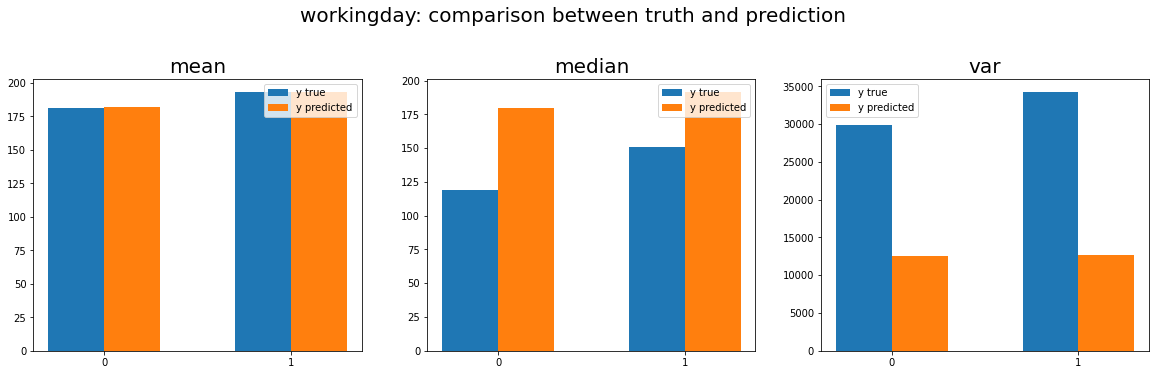

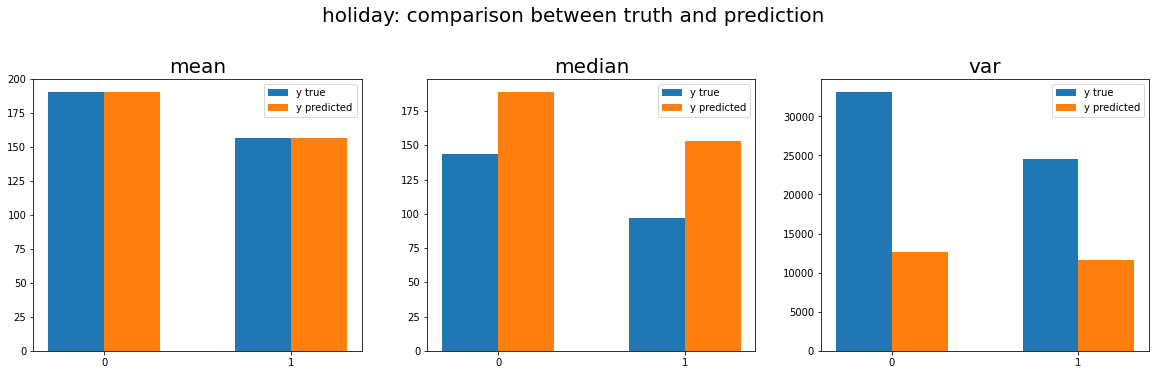

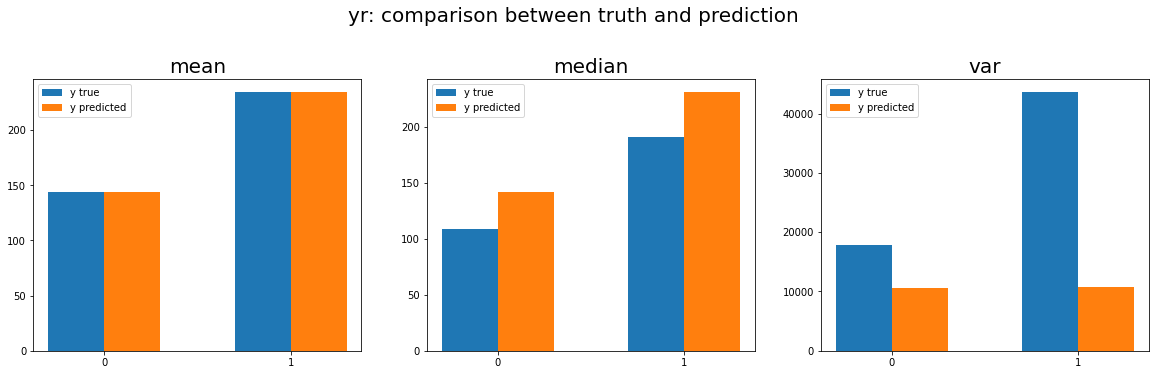

In [29]:
data_exploration_bike()

As we can see, the variance of each variable is very badly estimated by our model, and the mean for the demand depending on the hour of day column (hr) is especially incorrectly predicted; assuring that our model can acurately predict the demand depending on the hour is critcal to having a good R squared coefficient, as the hr column is highly correlated with the demand. To find how important the hr column is to predicting the demand, we will try different models.

## Part III: Model Testing

First, we implement a model with only the temp variable (the non-categorical column the most correlated to our demand).

In [30]:
def model_temp_only():
    X, y, df = load_bike_data()

    df = df[["temp", "demand"]]

    y = df["demand"].to_numpy()
    X = df.drop("demand", axis=1).to_numpy()

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - temp only)")
    
    return X, w, y, df

In [31]:
X, w, y, df = model_temp_only()

Weights: 2 components

Coefficients:
Bias                 7.590302332541086
temp                 373.6690238139917

Mean absolute error: 125.52
Root mean squared error: 165.86
Coefficient of determination: 0.16


Temperature alone is enough to describe demand with a 0.16 R squared. Now, let us try to see how relevant hour is on its own by one-hot encoding the variable in the dataset. This will create 24 variables, each corresponding to one hour of the day; since hour is the variable most correlated to our output variable, this is sure to be effective.

In [32]:
def model_hour_only():
    X, y, df = load_bike_data()

    hour = pd.get_dummies(df.hr, prefix="hr")
    df = pd.concat([df["demand"], hour], axis=1)

    y = df["demand"].to_numpy()
    X = df.drop("demand", axis=1).to_numpy()

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - hour only)")

    return X, w, y, df

In [33]:
X, w, y, df = model_hour_only()

Weights: 25 components

Coefficients:
Bias                 374371697728217.06
hr_0                 -374371697728163.7
hr_1                 -374371697728183.25
hr_2                 -374371697728196.94
hr_3                 -374371697728204.44
hr_4                 -374371697728210.6
hr_5                 -374371697728195.8
hr_6                 -374371697728140.94
hr_7                 -374371697728005.2
hr_8                 -374371697727857.2
hr_9                 -374371697727997.1
hr_10                -374371697728043.6
hr_11                -374371697728008.0
hr_12                -374371697727964.0
hr_13                -374371697727963.0
hr_14                -374371697727976.2
hr_15                -374371697727965.4
hr_16                -374371697727905.25
hr_17                -374371697727756.44
hr_18                -374371697727791.8
hr_19                -374371697727905.2
hr_20                -374371697727991.44
hr_21                -374371697728044.8
hr_22                -3743716977280

The hr variable has a R squared score of 0.5 on its own ! This means that it carries most of the information of our dataset, and even more information that could be deduced from the correlation itself. Next we will test a model with all variables one-hot encoded (except days, as it would clearly overfit our data, since there would be one variable for every day, so the number of individuals to number of variables ratio would only be of 1/24, which is way too high.

Also as we can see, the weights have strange large values; this is due to the fact that with one-hot encoding, since it is sure that one and only one of the variables will be "on" at any given time, the bias can take any value, since the weights on the variables can correct it back to the "real" bias value. With multiple categorical variables being one-hot encoded, the same can happen again, as one variable of each one-hot encoded variable is sure to be 1 at any given time, the weights from one variable can derive from their original value as long as it is corrected by the other variable. Thus, from now on, the coefficients of the values will not be analysable.

In [34]:
def model_all_variables():
    X, y, df = load_bike_data()
    
    season = pd.get_dummies(df.season, prefix="season")
    month = pd.get_dummies(df.mnth, prefix="mnth")
    year = pd.get_dummies(df.yr, prefix="yr")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    dayOfWeek = pd.get_dummies(df.dayOfWeek, prefix="dayOfWeek")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, month, year, workingday,
                    weather, dayOfWeek, holiday, hour], axis=1)
    
    y = df["demand"].to_numpy()
    X = df.drop("demand", axis=1).to_numpy()

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - all variables)")
    
    return X, w, y, df

In [35]:
X, w, y, df = model_all_variables()

Weights: 61 components

Coefficients:
Bias                 -3287449034800647.5
temp                 229.47279613872115
hum                  -82.84376702764325
windspeed            -30.467239847406844
season_1             93204320900616.83
season_2             93204320900656.0
season_3             93204320900648.75
season_4             93204320900684.06
mnth_1               107485739536674.39
mnth_2               107485739536678.69
mnth_3               107485739536689.56
mnth_4               107485739536680.4
mnth_5               107485739536692.92
mnth_6               107485739536677.94
mnth_7               107485739536658.33
mnth_8               107485739536678.67
mnth_9               107485739536704.48
mnth_10              107485739536690.25
mnth_11              107485739536665.47
mnth_12              107485739536668.36
yr_0                 1577210655215961.0
yr_1                 1577210655216045.0
workingday_0         1531539644338810.8
workingday_1         -17779893992024.58
weathe

With all the variables in our datasets, we obtain a R squared coefficient of 0.69, which is pretty mediocre, but seems to be the maximum that can be attained using a linear model. However, we observe that we have 61 components to our weights (39 more than with just the hour), for only 0.19 gained on our R2. We will try to trim down our model to have the optimal R2/number of variables ratio.

To remove variables, we can think logically: workingday contains most of the relevant information of week days (since what differentiates weeks days from the weekend is whether they are days of work, and it is improbable that consumer habits would change drastically in between week days), we can drop dayOfWeek and holiday (because there are very few days that are non-working and are not holidays). Also, most of the information of month is carried in season (which is also mostly contained in weather and tempature, as they are the most correlated on the correlation heatmap, but logically because what mostly change in between months is the climate) and year (as it describes long term changes in consumer tendencies), so we will drop the mnth column. 

In [36]:
def model_all_variables_trimmed():
    X, y, df = load_bike_data()
    
    print(df.columns)
    season = pd.get_dummies(df.season, prefix="season")
    year = pd.get_dummies(df.yr, prefix="yr")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, year, workingday,
                    weather, hour], axis=1)
    
    y = df["demand"].to_numpy()
    X = df.drop("demand", axis=1).to_numpy()

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - trimmed model)")
    
    return X, w, y, df

In [37]:
X, w, y, df = model_all_variables_trimmed()

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'dayOfWeek', 'days', 'demand'], dtype='object')
Weights: 40 components

Coefficients:
Bias                 31410054584152.043
temp                 239.13103129069313
hum                  -70.11770358086514
windspeed            -28.73115471762346
season_1             -54953805315583.93
season_2             -54953805315540.43
season_3             -54953805315555.62
season_4             -54953805315517.93
yr_0                 26837883695852.93
yr_1                 26837883695938.3
workingday_0         1152526478866.2336
workingday_1         1152526478873.348
weather_state_1      -4313108840646.7466
weather_state_2      -4313108840657.415
weather_state_3      -4313108840712.563
weather_state_4      -4313108840714.447
hr_0                 -133550602716.63249
hr_1                 -133550602734.13013
hr_2                 -133550602743.27393
hr_3                 -133550602753.81503
hr_4     

Despite having removed 21 components to the weight, we have lost almost no information, and the R2 coefficient has only dropped by 0.01. We can try to trim the weight some more. We will remove the humidity (hum) and the wind speed (windspeed) variables from the dataset, as they are almost not correlated with the demand. Also, we will remove the weather column, as the temperature and the season already describe most of the weather changes.

In [38]:
def model_all_variables_most_trimmed():
    X, y, df = load_bike_data()
    
    print(df.columns)
    season = pd.get_dummies(df.season, prefix="season")
    year = pd.get_dummies(df.yr, prefix="yr")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "demand"]], season, year, workingday, hour], axis=1)
    
    y = df["demand"].to_numpy()
    X = df.drop("demand", axis=1).to_numpy()

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - most trimmed model)")
    
    return X, w, y, df

In [39]:
X, w, y, df = model_all_variables_most_trimmed()

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'dayOfWeek', 'days', 'demand'], dtype='object')
Weights: 34 components

Coefficients:
Bias                 1108457999753337.8
temp                 253.38856765867126
season_1             -905497848461046.9
season_2             -905497848461009.9
season_3             -905497848461024.1
season_4             -905497848460986.8
yr_0                 -186147775733819.84
yr_1                 -186147775733731.4
workingday_0         -63785294351338.875
workingday_1         -63785294351334.02
hr_0                 46972918792728.74
hr_1                 46972918792709.484
hr_2                 46972918792700.08
hr_3                 46972918792688.24
hr_4                 46972918792684.21
hr_5                 46972918792701.87
hr_6                 46972918792759.45
hr_7                 46972918792894.46
hr_8                 46972918793037.2
hr_9                 46972918792891.93
hr_10             

6 variables down, and 0.02 lost on the R2 score. Every variable now is critical to our model. We will now create one last model without the year column, as, in the logic of our prediction, this column overfits our dataset; as we saw in the data exploration, the difference in demand between the two years of the dataset is very important, and it doesn't make sense to assume that there is a linear relationship between the year and the demand; since the year is too specific in describing the demand, we remove it from our dataset to avoid overfitting in future predictions.

In [40]:
def model_final():
    X, y, df = load_bike_data()
    
    print(df.columns)
    season = pd.get_dummies(df.season, prefix="season")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "demand"]], season, workingday, hour], axis=1)
    
    y = df["demand"].to_numpy()
    X = df.drop("demand", axis=1).to_numpy()

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - final model)")
    
    return X, w, y, df

In [41]:
X, w, y, df = model_final()

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'dayOfWeek', 'days', 'demand'], dtype='object')
Weights: 32 components

Coefficients:
Bias                 695432919332540.4
temp                 284.0390424705157
season_1             12670818751740.244
season_2             12670818751768.783
season_3             12670818751749.348
season_4             12670818751794.34
workingday_0         -454697299235976.8
workingday_1         -454697299235972.2
hr_0                 -253406438848405.47
hr_1                 -253406438848423.97
hr_2                 -253406438848433.1
hr_3                 -253406438848444.16
hr_4                 -253406438848447.88
hr_5                 -253406438848430.97
hr_6                 -253406438848373.38
hr_7                 -253406438848238.9
hr_8                 -253406438848096.7
hr_9                 -253406438848242.84
hr_10                -253406438848295.3
hr_11                -253406438848267.28
hr_12

Our final model has a coefficient of determination of 0.6, which is pretty mediocre, and cannot be improved much using a linear regression. However, we can use a trick to increase the precision of our linear model by adding a slope variable (containing the tendency of change of demand over the last two hours) and a "memory" of the last demand. Hypothetically, if the bike sharing system has a constant knowledge of the current demand, such predictions of the demand for the next hour could be made in real time, and so this model would make sense in some situations.

In [42]:
def model_absolute():
    X, y, df = load_bike_data()
        
    def coef_dir(df):
        coef_hour=[]

        for i in range (0, np.size(df.to_numpy(),0)):
            if(i>=2):
                coef_hour.append((df['demand'].iloc[i-2]-df['demand'].iloc[i-1])/((i-2)-(i-1)))
                
        df = df.loc[2:, :]
        df.insert(1, 'coef_hour', coef_hour)
        
        return df

    df = coef_dir(df)
    previous_hour = df['demand'].shift(periods=-1)
    df['previous_hour'] = previous_hour
    df = df[:-1]

    season = pd.get_dummies(df.season, prefix="season")
    month = pd.get_dummies(df.mnth, prefix="mnth")
    year = pd.get_dummies(df.yr, prefix="yr")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    dayOfWeek = pd.get_dummies(df.dayOfWeek, prefix="dayOfWeek")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "coef_hour", "previous_hour", "demand"]], season, month, year, workingday,
                    weather, dayOfWeek, holiday, hour], axis=1)

    
    X = df.drop(columns='demand', axis=1)
    
    y = df.demand
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_normalized, y)

    linear_regression_stats([model.intercept_] + list(model.coef_), X_normalized, y,
                            model.predict(X_normalized), df.drop("demand", axis=1).columns,
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - all variables + slope & memory)")
    
    return X, w, y, df

In [43]:
X, w, y, df = model_absolute()

Weights: 63 components

Coefficients:
Bias                 1253686445631265.2
temp                 84.62225251644675
hum                  -41.97547493316782
windspeed            -11.268458268016047
coef_hour            394.3025525017671
previous_hour        640.3950937247846
season_1             79732366875754.95
season_2             79732366875768.27
season_3             79732366875765.58
season_4             79732366875778.56
mnth_1               -245848678579735.16
mnth_2               -245848678579734.03
mnth_3               -245848678579730.56
mnth_4               -245848678579734.22
mnth_5               -245848678579729.0
mnth_6               -245848678579735.34
mnth_7               -245848678579741.84
mnth_8               -245848678579734.16
mnth_9               -245848678579724.84
mnth_10              -245848678579730.4
mnth_11              -245848678579738.25
mnth_12              -245848678579736.3
yr_0                 -625341793884164.1
yr_1                 -625341793884135.1

Using the slope & memory trick, we bump our R2 score to 0.88, which is descent given the fact that we cannot go further than 0.69 with a normal model.

## Part IV: Beyond Linear Regression

Now we will experiment using other models, such as polynomial regression, GBRs & random forests. We will one-hot encode our cyclical variables and ignore the days variable to avoid overfitting.

In [44]:
def model_polynomial():
    X, y, df = load_bike_data()
    
    season = pd.get_dummies(df.season, prefix="season")
    month = pd.get_dummies(df.mnth, prefix="mnth")
    year = pd.get_dummies(df.yr, prefix="yr")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    dayOfWeek = pd.get_dummies(df.dayOfWeek, prefix="dayOfWeek")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, month, year, workingday,
                    weather, dayOfWeek, holiday, hour], axis=1)
    
    X = df.drop(columns='demand', axis=1).to_numpy()
    y = df.demand

    poly = PolynomialFeatures(2)
    X = poly.fit_transform(X)
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3, test_size=0.2)

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    
    # Display only the first 50 weights
    linear_regression_stats([model.intercept_] + list(model.coef_), X_test, y_test,
                            model.predict(X_test), range(50),
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - polynomial regression)") 
    
    return X, w, y, df

In [45]:
X, w, y, df = model_polynomial()

Weights: 1892 components

Coefficients:
Bias                 -565856671135023.1
0                    453706089558032.0
1                    398319507516582.9
2                    -181372203020412.66
3                    258589399986588.56
4                    -11037823243591.514
5                    -3608501313896.939
6                    244243244573112.25
7                    397848525626195.94
8                    -75402447800346.53
9                    21291592296307.242
10                   -51923517237322.164
11                   43199302640342.4
12                   37203092342100.016
13                   210847182873706.75
14                   63141891809257.39
15                   -19951480979277.707
16                   -169325747509854.94
17                   -85105297555445.75
18                   -89713627792761.56
19                   105740157073682.77
20                   -116490748901414.95
21                   -8689424596687.358
22                   -146280247331512.6

In [46]:
def model_polynomial_bis():
    X, y, df = load_bike_data()
    
    season = pd.get_dummies(df.season, prefix="season")
    month = pd.get_dummies(df.mnth, prefix="mnth")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, workingday,
                    weather, holiday, hour], axis=1)
    
    X = df.drop(columns='demand', axis=1).to_numpy()
    y = df.demand

    poly = PolynomialFeatures(2)
    X = poly.fit_transform(X)
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3, test_size=0.2)

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    
    # Display only the first 50 weights
    linear_regression_stats([model.intercept_] + list(model.coef_), X_test, y_test,
                            model.predict(X_test), range(50),
                            "Scikit Learn Linear Regression (Bike Sharing Dataset - polynomial regression)") 
    
    return X, w, y, df

In [47]:
X, w, y, df = model_polynomial_bis()

Weights: 821 components

Coefficients:
Bias                 250285363322603.88
0                    1757172700.1106026
1                    -161228095002373.56
2                    194363367985306.28
3                    101372801435767.44
4                    126894193843493.92
5                    -21309853473872.03
6                    299351064352364.06
7                    46182781640188.984
8                    -157135021165049.16
9                    -614589045179921.2
10                   26835713048362.71
11                   239268979099876.78
12                   -158108856339248.38
13                   -92272212934519.02
14                   -128942535670618.25
15                   -83678270714767.89
16                   -164704576193659.06
17                   -12201363423435.576
18                   31322434964663.465
19                   -18963989827837.28
20                   29417745491618.613
21                   -21941076719116.76
22                   -17798560894914

In [48]:
def GBR_scikit_bike():
    X, y, df = load_bike_data()
    
    season = pd.get_dummies(df.season, prefix="season")
    month = pd.get_dummies(df.mnth, prefix="mnth")
    year = pd.get_dummies(df.yr, prefix="yr")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    dayOfWeek = pd.get_dummies(df.dayOfWeek, prefix="dayOfWeek")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, month, year, workingday,
                    weather, dayOfWeek, holiday, hour], axis=1)
    
    X = df.drop(columns='demand', axis=1).to_numpy()
    y = df.demand
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

    regr = GradientBoostingRegressor()
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)

    print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
    
    print(len(X))
    return X, w, y, df

In [49]:
X, w, y, df = GBR_scikit_bike()

Coefficient of determination: 0.79
17379


In [50]:
def GBR_scikit_bike_bis():
    X, y, df = load_bike_data()
    
    season = pd.get_dummies(df.season, prefix="season")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, workingday,
                    weather, holiday, hour], axis=1)
    
    X = df.drop(columns='demand', axis=1).to_numpy()
    y = df.demand
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

    regr = GradientBoostingRegressor()
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)

    print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
    
    print(len(X))
    return X, w, y, df

In [51]:
X, w, y, df = GBR_scikit_bike_bis()

Coefficient of determination: 0.73
17379


In [52]:
def random_forest_scikit_bike():
    X, y, df = load_bike_data()
    
    season = pd.get_dummies(df.season, prefix="season")
    month = pd.get_dummies(df.mnth, prefix="mnth")
    year = pd.get_dummies(df.yr, prefix="yr")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    dayOfWeek = pd.get_dummies(df.dayOfWeek, prefix="dayOfWeek")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, month, year, workingday,
                    weather, dayOfWeek, holiday, hour], axis=1)
    
    X = df.drop(columns='demand', axis=1).to_numpy()
    y = df.demand
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

    regr = RandomForestRegressor()
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)

    print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
    
    print(len(X))
    return X, w, y, df

In [53]:
X, w, y, df = random_forest_scikit_bike()

Coefficient of determination: 0.92
17379


In [54]:
def random_forest_scikit_bike_bis():
    X, y, df = load_bike_data()
    
    season = pd.get_dummies(df.season, prefix="season")
    workingday = pd.get_dummies(df.workingday, prefix="workingday")
    holiday = pd.get_dummies(df.holiday, prefix="holiday")
    weather = pd.get_dummies(df.weathersit, prefix="weather_state")
    hour = pd.get_dummies(df.hr, prefix="hr")
    
    df = pd.concat([df[["temp", "hum", "windspeed", "demand"]], season, workingday,
                    weather, holiday, hour], axis=1)
    
    X = df.drop(columns='demand', axis=1).to_numpy()
    y = df.demand
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

    regr = RandomForestRegressor()
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)

    print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
    
    print(len(X))
    return X, w, y, df

In [55]:
X, w, y, df = random_forest_scikit_bike_bis()

Coefficient of determination: 0.82
17379


As we can see, other models are much more effective at predicting the data than our linear regressions. However, it is possible that they are effective only because of the sheer number of variables they can apply on the dataset; specifically, the polynomial and random forest regressions seem to be somewhat dependent on the specific time events of our dataset (yearly, monthly and weekly variations) that cannot be generalised to real-world data without more knowledge on the intricate relationships between long time intervals and demand. However, with a R2 score of 0.82, the models are still quite robust despite all the removed information.